In [12]:
from os import listdir
from os.path import isfile, join

# Modify this path to your own MAESTRO dataset
maestro_dir = 'maestro-v2.0.0'

data_dirs = []
for year in ['2004', '2006', '2008', '2009', '2011', '2013', '2014', '2015', '2017', '2018']:
    data_dirs.append(maestro_dir + '/' + str(year))

data_files = []
for data_dir in data_dirs:
    data_files += [join(data_dir, f) for f in listdir(data_dir) if isfile(join(data_dir, f)) if 'midi' in f]

data_files.sort()

print('total midi files : ', len(data_files))

total midi files :  1282


In [13]:
import mido
import numpy as np


def get_eventlist(data_file):
    ON = 1
    OFF = 0
    CC = 2

    midi = mido.MidiFile(data_file)

    current_time = 0
    eventlist = []
    cc = False
    for msg in midi:
        #print(msg)
        current_time += msg.time

         # NOTE ON CASE
        if msg.type is 'note_on' and msg.velocity > 0:
            event = [current_time, ON, msg.note, msg.velocity]
            eventlist.append(event)

         # NOTE OFF CASE        
        elif msg.type is 'note_off' or (msg.type is 'note_on' and msg.velocity == 0):
            event = [current_time, OFF, msg.note, msg.velocity]
            eventlist.append(event)
            
        if msg.type is 'control_change':
            
            if msg.control != 64:
                continue
            
            if cc == False and msg.value > 0:
                cc = True
                event = [current_time, CC, 0, 1]
                eventlist.append(event)
                
            elif cc == True and msg.value == 0:
                cc = False
                event = [current_time, CC, 0, 0]
                eventlist.append(event)
                
    eventlist = np.array(eventlist)
    return eventlist


In [14]:
def second_to_hopindex(second, sample_rate, hop_size):
    return int(second * sample_rate / hop_size)

def get_roll(filename, sample_rate = 22050, hop_size = 256):
    eventlist = get_eventlist(filename)
    duration = eventlist[-1, 0]
    roll_length = second_to_hopindex(duration, sample_rate, hop_size)
    roll = np.zeros([int(roll_length), 128])
    current_roll = np.zeros(128)
    before_index = 0
    for event in eventlist:
        second = event[0]
        current_index = second_to_hopindex(event[0], sample_rate, hop_size)
        roll[before_index:current_index] = np.copy(current_roll)
        before_index = current_index

        if event[1] == 1:
            current_roll[int(event[2])] = event[3] / 128
        elif event[1] == 0:
            current_roll[int(event[2])] = event[3] / 128
        elif event[1] == 2:
            if event[3] == 1:
                current_roll[0] = 1
            else:
                current_roll[0] = 0

    return roll

In [15]:
import librosa

def logmelfilterbank(audio,
                     sampling_rate,
                     fft_size=1024,
                     hop_size=256,
                     win_length=None,
                     window='hann',
                     num_mels=80,
                     fmin=None,
                     fmax=None,
                     eps=1e-10,
                     ):
    """Compute log-Mel filterbank feature.

    Args:
        audio (ndarray): Audio signal (T,).
        sampling_rate (int): Sampling rate.
        fft_size (int): FFT size.
        hop_size (int): Hop size.
        win_length (int): Window length. If set to None, it will be the same as fft_size.
        window (str): Window function type.
        num_mels (int): Number of mel basis.
        fmin (int): Minimum frequency in mel basis calculation.
        fmax (int): Maximum frequency in mel basis calculation.
        eps (float): Epsilon value to avoid inf in log calculation.

    Returns:
        ndarray: Log Mel filterbank feature (#frames, num_mels).

    """
    # get amplitude spectrogram
    x_stft = librosa.stft(audio, n_fft=fft_size, hop_length=hop_size,
                          win_length=win_length, window=window, pad_mode="reflect")
    spc = np.abs(x_stft).T  # (#frames, #bins)
    pha = np.angle(x_stft).T
    
    spc = (np.log(np.maximum(spc, 1e-5)) - np.log(1e-5)) / -np.log(1e-5)
    
    return spc[:, :512]

def get_spec(filename, sample_rate=22050, hop_size=256):

    wav, sr = librosa.core.load(filename, sr=sample_rate)
    spec = logmelfilterbank(wav, sample_rate, fft_size=1024, hop_size=hop_size)
    
    return spec
    

### Show roll&spec

(83398, 128)


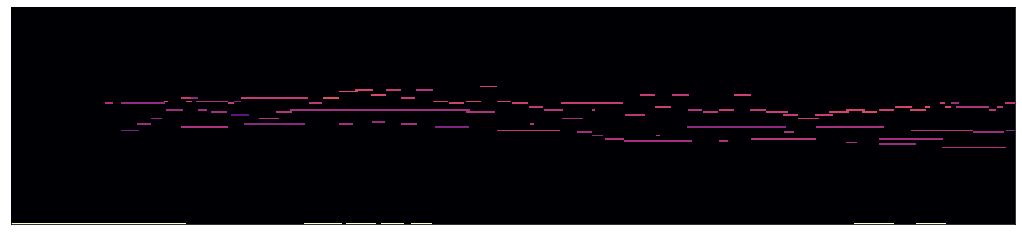

(83516, 512)


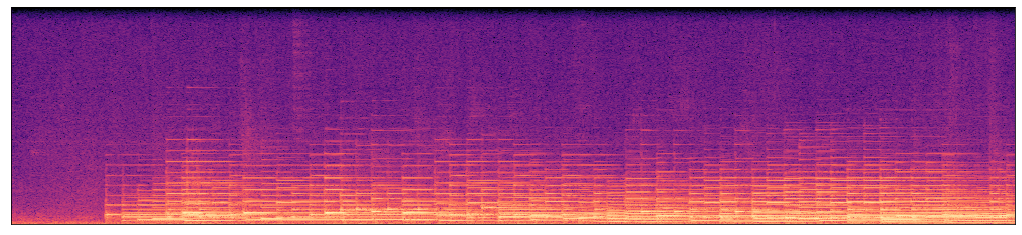

In [16]:
import librosa.display 
import matplotlib.pyplot as plt

roll = get_roll(data_files[0])
print(roll.shape)

plt.figure(figsize=[18, 4])
librosa.display.specshow(roll[:1000].T)
plt.show()

spec = get_spec(data_files[0][:-5] + '.wav')
print(spec.shape)

plt.figure(figsize=[18, 4])
librosa.display.specshow(spec[:1000].T)
plt.show()

### Save roll&spec npz

In [7]:
import os.path 
import ntpath
import time

save_dir = 'roll_n_spec22050_1024_256/'
for i, midi_file in enumerate(data_files):
    basename = ntpath.basename(midi_file)[:-5]
    wav_file = midi_file[:-5] + '.wav'
    if not os.path.exists(wav_file):
        print(wav_file)
        
    roll = get_roll(midi_file)
    spec = get_spec(wav_file)
    print(i, midi_file, roll.shape, spec.shape)
    length = min(len(roll), len(spec))
    roll = roll[:length]
    spec = spec[:length]
    
    data = {'roll': roll, 'spec': spec}
    np.savez(save_dir + basename, **data, allow_pickle=False)
    
    t0 = time.time()
    data = np.load(save_dir + basename + '.npz')
    t1 = time.time()
    print('load :', data['roll'].shape, data['spec'].shape, t1 - t0)

139 maestro-v2.0.0/2006/MIDI-Unprocessed_01_R2_2006_01_ORIG_MID--AUDIO_01_R2_2006_03_Track03_wav.midi (154656, 128) (154704, 512)
load : (154656, 128) (154656, 512) 0.0002608299255371094
140 maestro-v2.0.0/2006/MIDI-Unprocessed_02_R1_2006_01-04_ORIG_MID--AUDIO_02_R1_2006_01_Track01_wav.midi (165494, 128) (165664, 512)
load : (165494, 128) (165494, 512) 0.00017499923706054688
141 maestro-v2.0.0/2006/MIDI-Unprocessed_02_R1_2006_01-04_ORIG_MID--AUDIO_02_R1_2006_02_Track02_wav.midi (233899, 128) (234072, 512)
load : (233899, 128) (233899, 512) 0.00019860267639160156
142 maestro-v2.0.0/2006/MIDI-Unprocessed_02_R1_2006_01-04_ORIG_MID--AUDIO_02_R1_2006_03_Track03_wav.midi (115543, 128) (115712, 512)
load : (115543, 128) (115543, 512) 0.00018358230590820312
143 maestro-v2.0.0/2006/MIDI-Unprocessed_03_R1_2006_01-05_ORIG_MID--AUDIO_03_R1_2006_04_Track04_wav.midi (162431, 128) (162603, 512)
load : (162431, 128) (162431, 512) 0.00017523765563964844
144 maestro-v2.0.0/2006/MIDI-Unprocessed_03_R1_20

load : (157312, 128) (157312, 512) 0.0001881122589111328
183 maestro-v2.0.0/2006/MIDI-Unprocessed_11_R1_2006_01-06_ORIG_MID--AUDIO_11_R1_2006_01_Track01_wav.midi (57680, 128) (57857, 512)
load : (57680, 128) (57680, 512) 0.0001804828643798828
184 maestro-v2.0.0/2006/MIDI-Unprocessed_11_R1_2006_01-06_ORIG_MID--AUDIO_11_R1_2006_02_Track02_wav.midi (190888, 128) (191058, 512)
load : (190888, 128) (190888, 512) 0.00018358230590820312
185 maestro-v2.0.0/2006/MIDI-Unprocessed_11_R1_2006_01-06_ORIG_MID--AUDIO_11_R1_2006_04_Track04_wav.midi (86866, 128) (86986, 512)
load : (86866, 128) (86866, 512) 0.00018167495727539062
186 maestro-v2.0.0/2006/MIDI-Unprocessed_12_R1_2006_01-08_ORIG_MID--AUDIO_12_R1_2006_01_Track01_wav.midi (346030, 128) (346204, 512)
load : (346030, 128) (346030, 512) 0.0001895427703857422
187 maestro-v2.0.0/2006/MIDI-Unprocessed_12_R1_2006_01-08_ORIG_MID--AUDIO_12_R1_2006_02_Track02_wav.midi (105735, 128) (105905, 512)
load : (105735, 128) (105735, 512) 0.0001873970031738281

load : (277819, 128) (277819, 512) 0.0001838207244873047
227 maestro-v2.0.0/2006/MIDI-Unprocessed_21_R1_2006_01-04_ORIG_MID--AUDIO_21_R1_2006_01_Track01_wav.midi (91562, 128) (91658, 512)
load : (91562, 128) (91562, 512) 0.00016379356384277344
228 maestro-v2.0.0/2006/MIDI-Unprocessed_21_R1_2006_01-04_ORIG_MID--AUDIO_21_R1_2006_02_Track02_wav.midi (216536, 128) (216702, 512)
load : (216536, 128) (216536, 512) 0.00017070770263671875
229 maestro-v2.0.0/2006/MIDI-Unprocessed_22_R1_2006_01-04_ORIG_MID--AUDIO_22_R1_2006_01_Track01_wav.midi (177643, 128) (177800, 512)
load : (177643, 128) (177643, 512) 0.0001761913299560547
230 maestro-v2.0.0/2006/MIDI-Unprocessed_22_R1_2006_01-04_ORIG_MID--AUDIO_22_R1_2006_02_Track02_wav.midi (204725, 128) (204870, 512)
load : (204725, 128) (204725, 512) 0.00017905235290527344
231 maestro-v2.0.0/2006/MIDI-Unprocessed_22_R1_2006_01-04_ORIG_MID--AUDIO_22_R1_2006_04_Track04_wav.midi (301798, 128) (301971, 512)
load : (301798, 128) (301798, 512) 0.00018835067749

load : (56508, 128) (56508, 512) 0.00020074844360351562
272 maestro-v2.0.0/2008/MIDI-Unprocessed_04_R1_2008_01-04_ORIG_MID--AUDIO_04_R1_2008_wav--4.midi (109351, 128) (109540, 512)
load : (109351, 128) (109351, 512) 0.00017952919006347656
273 maestro-v2.0.0/2008/MIDI-Unprocessed_04_R2_2008_01-04_ORIG_MID--AUDIO_04_R2_2008_wav--1.midi (54874, 128) (55041, 512)
load : (54874, 128) (54874, 512) 0.0001857280731201172
274 maestro-v2.0.0/2008/MIDI-Unprocessed_04_R2_2008_01-04_ORIG_MID--AUDIO_04_R2_2008_wav--3.midi (69456, 128) (69585, 512)
load : (69456, 128) (69456, 512) 0.0001862049102783203
275 maestro-v2.0.0/2008/MIDI-Unprocessed_04_R2_2008_01-04_ORIG_MID--AUDIO_04_R2_2008_wav--4.midi (137301, 128) (137484, 512)
load : (137301, 128) (137301, 512) 0.0001723766326904297
276 maestro-v2.0.0/2008/MIDI-Unprocessed_04_R3_2008_01-07_ORIG_MID--AUDIO_04_R3_2008_wav--1.midi (111063, 128) (111237, 512)
load : (111063, 128) (111063, 512) 0.00017404556274414062
277 maestro-v2.0.0/2008/MIDI-Unprocessed

load : (110558, 128) (110558, 512) 0.00018143653869628906
318 maestro-v2.0.0/2008/MIDI-Unprocessed_09_R1_2008_01-05_ORIG_MID--AUDIO_09_R1_2008_wav--1.midi (38751, 128) (38924, 512)
load : (38751, 128) (38751, 512) 0.00017952919006347656
319 maestro-v2.0.0/2008/MIDI-Unprocessed_09_R1_2008_01-05_ORIG_MID--AUDIO_09_R1_2008_wav--2.midi (60713, 128) (60879, 512)
load : (60713, 128) (60713, 512) 0.00017690658569335938
320 maestro-v2.0.0/2008/MIDI-Unprocessed_09_R1_2008_01-05_ORIG_MID--AUDIO_09_R1_2008_wav--3.midi (47400, 128) (47566, 512)
load : (47400, 128) (47400, 512) 0.00017309188842773438
321 maestro-v2.0.0/2008/MIDI-Unprocessed_09_R1_2008_01-05_ORIG_MID--AUDIO_09_R1_2008_wav--4.midi (26544, 128) (26718, 512)
load : (26544, 128) (26544, 512) 0.0001747608184814453
322 maestro-v2.0.0/2008/MIDI-Unprocessed_09_R1_2008_01-05_ORIG_MID--AUDIO_09_R1_2008_wav--5.midi (63366, 128) (63548, 512)
load : (63366, 128) (63366, 512) 0.00019550323486328125
323 maestro-v2.0.0/2008/MIDI-Unprocessed_09_R2_2

load : (106542, 128) (106542, 512) 0.00019216537475585938
364 maestro-v2.0.0/2008/MIDI-Unprocessed_12_R3_2008_01-04_ORIG_MID--AUDIO_12_R3_2008_wav--2.midi (106261, 128) (106294, 512)
load : (106261, 128) (106261, 512) 0.00018262863159179688
365 maestro-v2.0.0/2008/MIDI-Unprocessed_12_R3_2008_01-04_ORIG_MID--AUDIO_12_R3_2008_wav--3.midi (28853, 128) (29530, 512)
load : (28853, 128) (28853, 512) 0.00017547607421875
366 maestro-v2.0.0/2008/MIDI-Unprocessed_13_R1_2008_01-04_ORIG_MID--AUDIO_13_R1_2008_wav--1.midi (40175, 128) (40296, 512)
load : (40175, 128) (40175, 512) 0.00016617774963378906
367 maestro-v2.0.0/2008/MIDI-Unprocessed_13_R1_2008_01-04_ORIG_MID--AUDIO_13_R1_2008_wav--2.midi (32742, 128) (32916, 512)
load : (32742, 128) (32742, 512) 0.000164031982421875
368 maestro-v2.0.0/2008/MIDI-Unprocessed_13_R1_2008_01-04_ORIG_MID--AUDIO_13_R1_2008_wav--4.midi (115013, 128) (115188, 512)
load : (115013, 128) (115013, 512) 0.0001785755157470703
369 maestro-v2.0.0/2008/MIDI-Unprocessed_14_R

load : (58088, 128) (58088, 512) 0.00017309188842773438
409 maestro-v2.0.0/2009/MIDI-Unprocessed_04_R1_2009_01-03_ORIG_MID--AUDIO_04_R1_2009_04_R1_2009_02_WAV.midi (126743, 128) (126917, 512)
load : (126743, 128) (126743, 512) 0.0001785755157470703
410 maestro-v2.0.0/2009/MIDI-Unprocessed_04_R1_2009_04-06_ORIG_MID--AUDIO_04_R1_2009_04_R1_2009_04_WAV.midi (71061, 128) (71062, 512)
load : (71061, 128) (71061, 512) 0.0001819133758544922
411 maestro-v2.0.0/2009/MIDI-Unprocessed_04_R1_2009_04-06_ORIG_MID--AUDIO_04_R1_2009_04_R1_2009_05_WAV.midi (138433, 128) (138603, 512)
load : (138433, 128) (138433, 512) 0.0001735687255859375
412 maestro-v2.0.0/2009/MIDI-Unprocessed_04_R1_2009_04-06_ORIG_MID--AUDIO_04_R1_2009_04_R1_2009_06_WAV.midi (32125, 128) (32288, 512)
load : (32125, 128) (32125, 512) 0.00017070770263671875
413 maestro-v2.0.0/2009/MIDI-Unprocessed_05_R1_2009_01-02_ORIG_MID--AUDIO_05_R1_2009_05_R1_2009_01_WAV.midi (136546, 128) (136718, 512)
load : (136546, 128) (136546, 512) 0.000184

452 maestro-v2.0.0/2009/MIDI-Unprocessed_10_R2_2009_01_ORIG_MID--AUDIO_10_R2_2009_10_R2_2009_01_WAV.midi (163624, 128) (163797, 512)
load : (163624, 128) (163624, 512) 0.0001761913299560547
453 maestro-v2.0.0/2009/MIDI-Unprocessed_10_R2_2009_01_ORIG_MID--AUDIO_10_R2_2009_10_R2_2009_02_WAV.midi (115885, 128) (116066, 512)
load : (115885, 128) (115885, 512) 0.00017595291137695312
454 maestro-v2.0.0/2009/MIDI-Unprocessed_10_R2_2009_01_ORIG_MID--AUDIO_10_R2_2009_10_R2_2009_03_WAV.midi (38051, 128) (38230, 512)
load : (38051, 128) (38051, 512) 0.0001723766326904297
455 maestro-v2.0.0/2009/MIDI-Unprocessed_10_R2_2009_01_ORIG_MID--AUDIO_10_R2_2009_10_R2_2009_04_WAV.midi (89032, 128) (89195, 512)
load : (89032, 128) (89032, 512) 0.0001766681671142578
456 maestro-v2.0.0/2009/MIDI-Unprocessed_11_R1_2009_01-05_ORIG_MID--AUDIO_11_R1_2009_11_R1_2009_01_WAV.midi (231811, 128) (231912, 512)
load : (231811, 128) (231811, 512) 0.0001766681671142578
457 maestro-v2.0.0/2009/MIDI-Unprocessed_11_R1_2009_01

load : (452723, 128) (452723, 512) 0.0001785755157470703
496 maestro-v2.0.0/2009/MIDI-Unprocessed_17_R2_2009_01_ORIG_MID--AUDIO_17_R2_2009_17_R2_2009_01_WAV.midi (81995, 128) (81996, 512)
load : (81995, 128) (81995, 512) 0.0001811981201171875
497 maestro-v2.0.0/2009/MIDI-Unprocessed_17_R2_2009_01_ORIG_MID--AUDIO_17_R2_2009_17_R2_2009_02_WAV.midi (84128, 128) (84129, 512)
load : (84128, 128) (84128, 512) 0.0001862049102783203
498 maestro-v2.0.0/2009/MIDI-Unprocessed_17_R2_2009_01_ORIG_MID--AUDIO_17_R2_2009_17_R2_2009_03_WAV.midi (35078, 128) (35252, 512)
load : (35078, 128) (35078, 512) 0.00017881393432617188
499 maestro-v2.0.0/2009/MIDI-Unprocessed_17_R2_2009_01_ORIG_MID--AUDIO_17_R2_2009_17_R2_2009_04_WAV.midi (89989, 128) (90155, 512)
load : (89989, 128) (89989, 512) 0.00017452239990234375
500 maestro-v2.0.0/2009/MIDI-Unprocessed_18_R1_2009_01-03_ORIG_MID--AUDIO_18_R1_2009_18_R1_2009_01_WAV.midi (56733, 128) (56903, 512)
load : (56733, 128) (56733, 512) 0.000179290771484375
501 maest

load : (44030, 128) (44030, 512) 0.00020170211791992188
542 maestro-v2.0.0/2011/MIDI-Unprocessed_03_R3_2011_MID--AUDIO_R3-D1_07_Track07_wav.midi (104166, 128) (104343, 512)
load : (104166, 128) (104166, 512) 0.00017786026000976562
543 maestro-v2.0.0/2011/MIDI-Unprocessed_04_R1_2011_MID--AUDIO_R1-D2_02_Track02_wav.midi (36174, 128) (36320, 512)
load : (36174, 128) (36174, 512) 0.00019669532775878906
544 maestro-v2.0.0/2011/MIDI-Unprocessed_04_R1_2011_MID--AUDIO_R1-D2_03_Track03_wav.midi (51543, 128) (51707, 512)
load : (51543, 128) (51543, 512) 0.0001747608184814453
545 maestro-v2.0.0/2011/MIDI-Unprocessed_04_R1_2011_MID--AUDIO_R1-D2_04_Track04_wav.midi (23011, 128) (23174, 512)
load : (23011, 128) (23011, 512) 0.00016999244689941406
546 maestro-v2.0.0/2011/MIDI-Unprocessed_04_R1_2011_MID--AUDIO_R1-D2_06_Track06_wav.midi (78940, 128) (79092, 512)
load : (78940, 128) (78940, 512) 0.00018024444580078125
547 maestro-v2.0.0/2011/MIDI-Unprocessed_04_R2_2011_MID--AUDIO_R2-D2_02_Track02_wav.mi

load : (48626, 128) (48626, 512) 0.0001761913299560547
590 maestro-v2.0.0/2011/MIDI-Unprocessed_11_R1_2011_MID--AUDIO_R1-D4_11_Track11_wav.midi (20189, 128) (20358, 512)
load : (20189, 128) (20189, 512) 0.000171661376953125
591 maestro-v2.0.0/2011/MIDI-Unprocessed_12_R1_2011_MID--AUDIO_R1-D4_13_Track13_wav.midi (56966, 128) (57148, 512)
load : (56966, 128) (56966, 512) 0.00017905235290527344
592 maestro-v2.0.0/2011/MIDI-Unprocessed_12_R1_2011_MID--AUDIO_R1-D4_14_Track14_wav.midi (112605, 128) (112778, 512)
load : (112605, 128) (112605, 512) 0.00017786026000976562
593 maestro-v2.0.0/2011/MIDI-Unprocessed_12_R1_2011_MID--AUDIO_R1-D4_15_Track15_wav.midi (34962, 128) (35136, 512)
load : (34962, 128) (34962, 512) 0.00016880035400390625
594 maestro-v2.0.0/2011/MIDI-Unprocessed_12_R2_2011_MID--AUDIO_R2-D4_02_Track02_wav.midi (64829, 128) (65238, 512)
load : (64829, 128) (64829, 512) 0.00016379356384277344
595 maestro-v2.0.0/2011/MIDI-Unprocessed_12_R2_2011_MID--AUDIO_R2-D4_03_Track03_wav.midi

load : (19995, 128) (19995, 512) 0.00017452239990234375
638 maestro-v2.0.0/2011/MIDI-Unprocessed_18_R1_2011_MID--AUDIO_R1-D7_10_Track10_wav.midi (86691, 128) (86821, 512)
load : (86691, 128) (86691, 512) 0.00017786026000976562
639 maestro-v2.0.0/2011/MIDI-Unprocessed_19_R1_2011_MID--AUDIO_R1-D7_12_Track12_wav.midi (54474, 128) (54480, 512)
load : (54474, 128) (54474, 512) 0.00021147727966308594
640 maestro-v2.0.0/2011/MIDI-Unprocessed_19_R1_2011_MID--AUDIO_R1-D7_13_Track13_wav.midi (77797, 128) (77798, 512)
load : (77797, 128) (77797, 512) 0.0001804828643798828
641 maestro-v2.0.0/2011/MIDI-Unprocessed_19_R1_2011_MID--AUDIO_R1-D7_14_Track14_wav.midi (25831, 128) (26258, 512)
load : (25831, 128) (25831, 512) 0.0002493858337402344
642 maestro-v2.0.0/2011/MIDI-Unprocessed_19_R1_2011_MID--AUDIO_R1-D7_15_Track15_wav.midi (105393, 128) (105428, 512)
load : (105393, 128) (105393, 512) 0.0001952648162841797
643 maestro-v2.0.0/2011/MIDI-Unprocessed_20_R1_2011_MID--AUDIO_R1-D8_02_Track02_wav.midi

load : (92353, 128) (92353, 512) 0.0001690387725830078
686 maestro-v2.0.0/2013/ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_08_R3_2013_wav--1.midi (103731, 128) (103904, 512)
load : (103731, 128) (103731, 512) 0.00017642974853515625
687 maestro-v2.0.0/2013/ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_08_R3_2013_wav--2.midi (141489, 128) (141662, 512)
load : (141489, 128) (141489, 512) 0.00022912025451660156
688 maestro-v2.0.0/2013/ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_08_R3_2013_wav--3.midi (88031, 128) (88202, 512)
load : (88031, 128) (88031, 512) 0.00017881393432617188
689 maestro-v2.0.0/2013/ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_01_R1_2013_wav--1.midi (76499, 128) (76672, 512)
load : (76499, 128) (76499, 512) 0.00018835067749023438
690 maestro-v2.0.0/2013/ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_01_R1_2013_wav--2.midi (56977, 128) (57152, 512)
load : (56977, 128) (56977, 512) 0.00021409988403320312
691 maestro-v2.0.0/2013/ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_01_R1_2013_wav--3.midi (52041, 128) (522

735 maestro-v2.0.0/2013/ORIG-MIDI_02_7_10_13_Group_MID--AUDIO_12_R3_2013_wav--2.midi (58534, 128) (58707, 512)
load : (58534, 128) (58534, 512) 0.0001811981201171875
736 maestro-v2.0.0/2013/ORIG-MIDI_02_7_10_13_Group_MID--AUDIO_12_R3_2013_wav--3.midi (60421, 128) (60594, 512)
load : (60421, 128) (60421, 512) 0.00018668174743652344
737 maestro-v2.0.0/2013/ORIG-MIDI_02_7_10_13_Group_MID--AUDIO_12_R3_2013_wav--4.midi (133145, 128) (133318, 512)
load : (133145, 128) (133145, 512) 0.00017786026000976562
738 maestro-v2.0.0/2013/ORIG-MIDI_02_7_10_13_Group_MID--AUDIO_14_R3_2013_wav--1.midi (101855, 128) (102024, 512)
load : (101855, 128) (101855, 512) 0.00017690658569335938
739 maestro-v2.0.0/2013/ORIG-MIDI_02_7_10_13_Group_MID--AUDIO_14_R3_2013_wav--2.midi (194198, 128) (194374, 512)
load : (194198, 128) (194198, 512) 0.00017595291137695312
740 maestro-v2.0.0/2013/ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_05_R1_2013_wav--1.midi (60781, 128) (60954, 512)
load : (60781, 128) (60781, 512) 0.00017189

784 maestro-v2.0.0/2013/ORIG-MIDI_03_7_10_13_Group_MID--AUDIO_15_R3_2013_wav--2.midi (66826, 128) (66864, 512)
load : (66826, 128) (66826, 512) 0.0001780986785888672
785 maestro-v2.0.0/2013/ORIG-MIDI_03_7_10_13_Group_MID--AUDIO_17_R3_2013_wav--1.midi (53127, 128) (53252, 512)
load : (53127, 128) (53127, 512) 0.0001811981201171875
786 maestro-v2.0.0/2013/ORIG-MIDI_03_7_10_13_Group_MID--AUDIO_17_R3_2013_wav--2.midi (110837, 128) (110983, 512)
load : (110837, 128) (110837, 512) 0.00017786026000976562
787 maestro-v2.0.0/2013/ORIG-MIDI_03_7_10_13_Group_MID--AUDIO_17_R3_2013_wav--3.midi (230334, 128) (230439, 512)
load : (230334, 128) (230334, 512) 0.00022983551025390625
788 maestro-v2.0.0/2013/ORIG-MIDI_03_7_10_13_Group_MID--AUDIO_18_R3_2013_wav--1.midi (86188, 128) (86261, 512)
load : (86188, 128) (86188, 512) 0.0001838207244873047
789 maestro-v2.0.0/2013/ORIG-MIDI_03_7_10_13_Group_MID--AUDIO_18_R3_2013_wav--2.midi (158143, 128) (158316, 512)
load : (158143, 128) (158143, 512) 0.0001754760

load : (134397, 128) (134397, 512) 0.00017189979553222656
833 maestro-v2.0.0/2014/MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--8.midi (178070, 128) (178240, 512)
load : (178070, 128) (178070, 512) 0.00018525123596191406
834 maestro-v2.0.0/2014/MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_04_R2_2014_wav.midi (381413, 128) (381579, 512)
load : (381413, 128) (381413, 512) 0.00018072128295898438
835 maestro-v2.0.0/2014/MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_07_R2_2014_wav.midi (308593, 128) (308764, 512)
load : (308593, 128) (308593, 512) 0.0001747608184814453
836 maestro-v2.0.0/2014/MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_08_R2_2014_wav.midi (403476, 128) (403632, 512)
load : (403476, 128) (403476, 512) 0.0001819133758544922
837 maestro-v2.0.0/2014/MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_10_R2_2014_wav.midi (340059, 128) (340348, 512)
load : (340059, 128) (340059, 512) 0.00018095970153808594
838 maestro-v2.0.0/20

load : (62985, 128) (62985, 512) 0.0001773834228515625
880 maestro-v2.0.0/2014/MIDI-UNPROCESSED_14-15_R1_2014_MID--AUDIO_15_R1_2014_wav--4.midi (55109, 128) (55282, 512)
load : (55109, 128) (55109, 512) 0.00018072128295898438
881 maestro-v2.0.0/2014/MIDI-UNPROCESSED_14-15_R1_2014_MID--AUDIO_15_R1_2014_wav--5.midi (83872, 128) (84047, 512)
load : (83872, 128) (83872, 512) 0.00018334388732910156
882 maestro-v2.0.0/2014/MIDI-UNPROCESSED_14-15_R1_2014_MID--AUDIO_15_R1_2014_wav--6.midi (284388, 128) (284564, 512)
load : (284388, 128) (284388, 512) 0.00022554397583007812
883 maestro-v2.0.0/2014/MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_16_R1_2014_wav--1.midi (41326, 128) (41507, 512)
load : (41326, 128) (41326, 512) 0.00017952919006347656
884 maestro-v2.0.0/2014/MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_16_R1_2014_wav--2.midi (227553, 128) (227731, 512)
load : (227553, 128) (227553, 512) 0.000179290771484375
885 maestro-v2.0.0/2014/MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_16_R1_2014_wav--3.

927 maestro-v2.0.0/2015/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_03_R1_2015_wav--4.midi (93019, 128) (93186, 512)
load : (93019, 128) (93019, 512) 0.0001659393310546875
928 maestro-v2.0.0/2015/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_04_R1_2015_wav--1.midi (27550, 128) (27694, 512)
load : (27550, 128) (27550, 512) 0.00017952919006347656
929 maestro-v2.0.0/2015/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_04_R1_2015_wav--2.midi (51689, 128) (51853, 512)
load : (51689, 128) (51689, 512) 0.0001888275146484375
930 maestro-v2.0.0/2015/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_04_R1_2015_wav--3.midi (48298, 128) (48411, 512)
load : (48298, 128) (48298, 512) 0.00017213821411132812
931 maestro-v2.0.0/2015/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_04_R1_2015_wav--4.midi (24105, 128) (24257, 512)
load : (24105, 128) (24105, 512) 0.00017189979553222656
932 maestro-v2.0.0/2015/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_05_R1_2015_wav--1.midi (58967, 128) (59281, 512)
lo

load : (95274, 128) (95274, 512) 0.00017380714416503906
974 maestro-v2.0.0/2015/MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_14_R1_2015_wav--4.midi (26955, 128) (27114, 512)
load : (26955, 128) (26955, 512) 0.00017499923706054688
975 maestro-v2.0.0/2015/MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_15_R1_2015_wav--1.midi (56900, 128) (57066, 512)
load : (56900, 128) (56900, 512) 0.00017070770263671875
976 maestro-v2.0.0/2015/MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_15_R1_2015_wav--2.midi (14141, 128) (14187, 512)
load : (14141, 128) (14141, 512) 0.00016951560974121094
977 maestro-v2.0.0/2015/MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_15_R1_2015_wav--3.midi (56234, 128) (56400, 512)
load : (56234, 128) (56234, 512) 0.0001671314239501953
978 maestro-v2.0.0/2015/MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_15_R1_2015_wav--4.midi (52655, 128) (52701, 512)
load : (52655, 128) (52655, 512) 0.0002238750457763672
979 maestro-v2.0.0/2015/MIDI-Unprocessed_R1_D2-13-20_mid

load : (72236, 128) (72236, 512) 0.000171661376953125
1020 maestro-v2.0.0/2015/MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_11_R2_2015_wav--1.midi (118369, 128) (118543, 512)
load : (118369, 128) (118369, 512) 0.0001723766326904297
1021 maestro-v2.0.0/2015/MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_11_R2_2015_wav--2.midi (61184, 128) (62070, 512)
load : (61184, 128) (61184, 512) 0.0001785755157470703
1022 maestro-v2.0.0/2015/MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_11_R2_2015_wav--4.midi (142398, 128) (142575, 512)
load : (142398, 128) (142398, 512) 0.0001933574676513672
1023 maestro-v2.0.0/2015/MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp3_12_R2_2015_wav--1.midi (99599, 128) (99777, 512)
load : (99599, 128) (99599, 512) 0.0001804828643798828
1024 maestro-v2.0.0/2015/MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp3_12_R2_2015_wav--2.midi (60463, 128) (60643, 512)
load : (60463, 128) (60463, 512) 0.00017189979553222656
1025 maestro-v2.0.0/

1064 maestro-v2.0.0/2017/MIDI-Unprocessed_046_PIANO046_MID--AUDIO-split_07-06-17_Piano-e_2-02_wav--4.midi (96258, 128) (96431, 512)
load : (96258, 128) (96258, 512) 0.00017523765563964844
1065 maestro-v2.0.0/2017/MIDI-Unprocessed_047_PIANO047_MID--AUDIO-split_07-06-17_Piano-e_2-04_wav--1.midi (52561, 128) (52690, 512)
load : (52561, 128) (52561, 512) 0.000171661376953125
1066 maestro-v2.0.0/2017/MIDI-Unprocessed_047_PIANO047_MID--AUDIO-split_07-06-17_Piano-e_2-04_wav--2.midi (37065, 128) (37229, 512)
load : (37065, 128) (37065, 512) 0.0002048015594482422
1067 maestro-v2.0.0/2017/MIDI-Unprocessed_047_PIANO047_MID--AUDIO-split_07-06-17_Piano-e_2-04_wav--3.midi (83288, 128) (83461, 512)
load : (83288, 128) (83288, 512) 0.00018310546875
1068 maestro-v2.0.0/2017/MIDI-Unprocessed_047_PIANO047_MID--AUDIO-split_07-06-17_Piano-e_2-04_wav--4.midi (86851, 128) (87018, 512)
load : (86851, 128) (86851, 512) 0.0001819133758544922
1069 maestro-v2.0.0/2017/MIDI-Unprocessed_048_PIANO048_MID--AUDIO-spli

load : (52141, 128) (52141, 512) 0.0001747608184814453
1108 maestro-v2.0.0/2017/MIDI-Unprocessed_057_PIANO057_MID--AUDIO-split_07-07-17_Piano-e_1-07_wav--4.midi (25073, 128) (25208, 512)
load : (25073, 128) (25073, 512) 0.00017571449279785156
1109 maestro-v2.0.0/2017/MIDI-Unprocessed_057_PIANO057_MID--AUDIO-split_07-07-17_Piano-e_1-07_wav--5.midi (100579, 128) (100753, 512)
load : (100579, 128) (100579, 512) 0.00017547607421875
1110 maestro-v2.0.0/2017/MIDI-Unprocessed_058_PIANO058_MID--AUDIO-split_07-07-17_Piano-e_2-02_wav--1.midi (88101, 128) (88491, 512)
load : (88101, 128) (88101, 512) 0.0002110004425048828
1111 maestro-v2.0.0/2017/MIDI-Unprocessed_058_PIANO058_MID--AUDIO-split_07-07-17_Piano-e_2-02_wav--2.midi (16536, 128) (16663, 512)
load : (16536, 128) (16536, 512) 0.0001766681671142578
1112 maestro-v2.0.0/2017/MIDI-Unprocessed_058_PIANO058_MID--AUDIO-split_07-07-17_Piano-e_2-02_wav--3.midi (55598, 128) (55709, 512)
load : (55598, 128) (55598, 512) 0.00017547607421875
1113 maes

load : (71238, 128) (71238, 512) 0.00017786026000976562
1152 maestro-v2.0.0/2017/MIDI-Unprocessed_072_PIANO072_MID--AUDIO-split_07-08-17_Piano-e_1-06_wav--4.midi (94851, 128) (95021, 512)
load : (94851, 128) (94851, 512) 0.0001773834228515625
1153 maestro-v2.0.0/2017/MIDI-Unprocessed_073_PIANO073_MID--AUDIO-split_07-08-17_Piano-e_2-02_wav--1.midi (114666, 128) (114839, 512)
load : (114666, 128) (114666, 512) 0.00018596649169921875
1154 maestro-v2.0.0/2017/MIDI-Unprocessed_073_PIANO073_MID--AUDIO-split_07-08-17_Piano-e_2-02_wav--2.midi (63129, 128) (63934, 512)
load : (63129, 128) (63129, 512) 0.00019311904907226562
1155 maestro-v2.0.0/2017/MIDI-Unprocessed_073_PIANO073_MID--AUDIO-split_07-08-17_Piano-e_2-02_wav--4.midi (169039, 128) (169209, 512)
load : (169039, 128) (169039, 512) 0.0001819133758544922
1156 maestro-v2.0.0/2017/MIDI-Unprocessed_074_PIANO074_MID--AUDIO-split_07-08-17_Piano-e_2-04_wav--1.midi (122676, 128) (123302, 512)
load : (122676, 128) (122676, 512) 0.000174760818481

load : (56654, 128) (56654, 512) 0.00017452239990234375
1197 maestro-v2.0.0/2018/MIDI-Unprocessed_Recital1-3_MID--AUDIO_01_R1_2018_wav--2.midi (108918, 128) (109214, 512)
load : (108918, 128) (108918, 512) 0.00018072128295898438
1198 maestro-v2.0.0/2018/MIDI-Unprocessed_Recital1-3_MID--AUDIO_01_R1_2018_wav--3.midi (277662, 128) (277828, 512)
load : (277662, 128) (277662, 512) 0.00018405914306640625
1199 maestro-v2.0.0/2018/MIDI-Unprocessed_Recital1-3_MID--AUDIO_01_R1_2018_wav--4.midi (121232, 128) (121402, 512)
load : (121232, 128) (121232, 512) 0.00017142295837402344
1200 maestro-v2.0.0/2018/MIDI-Unprocessed_Recital1-3_MID--AUDIO_02_R1_2018_wav--1.midi (423418, 128) (423585, 512)
load : (423418, 128) (423418, 512) 0.00019097328186035156
1201 maestro-v2.0.0/2018/MIDI-Unprocessed_Recital1-3_MID--AUDIO_02_R1_2018_wav--2.midi (136971, 128) (137144, 512)
load : (136971, 128) (136971, 512) 0.00017642974853515625
1202 maestro-v2.0.0/2018/MIDI-Unprocessed_Recital1-3_MID--AUDIO_02_R1_2018_wav-

load : (268256, 128) (268256, 512) 0.00018167495727539062
1245 maestro-v2.0.0/2018/MIDI-Unprocessed_Recital5-7_MID--AUDIO_05_R1_2018_wav--3.midi (233479, 128) (234101, 512)
load : (233479, 128) (233479, 512) 0.00017905235290527344
1246 maestro-v2.0.0/2018/MIDI-Unprocessed_Recital5-7_MID--AUDIO_06_R1_2018_wav--1.midi (228236, 128) (228386, 512)
load : (228236, 128) (228236, 512) 0.00017571449279785156
1247 maestro-v2.0.0/2018/MIDI-Unprocessed_Recital5-7_MID--AUDIO_06_R1_2018_wav--2.midi (250026, 128) (250199, 512)
load : (250026, 128) (250026, 512) 0.00018739700317382812
1248 maestro-v2.0.0/2018/MIDI-Unprocessed_Recital5-7_MID--AUDIO_06_R1_2018_wav--3.midi (251730, 128) (251886, 512)
load : (251730, 128) (251730, 512) 0.00017833709716796875
1249 maestro-v2.0.0/2018/MIDI-Unprocessed_Recital5-7_MID--AUDIO_07_R1_2018_wav--1.midi (162858, 128) (163031, 512)
load : (162858, 128) (162858, 512) 0.00017714500427246094
1250 maestro-v2.0.0/2018/MIDI-Unprocessed_Recital5-7_MID--AUDIO_07_R1_2018_wa